In [1]:
import numpy as np
from nbdt.model import SoftNBDT, HardNBDT
from nbdt.models import ResNet18, wrn28_10_cifar10, wrn28_10_cifar100, wrn28_10  # use wrn28_10 for TinyImagenet200
from captum.attr import GuidedGradCam
from captum.attr import visualization as vis
from torchvision import transforms
# from nbdt.graph import wnid_to_name
from nbdt.utils import DATASET_TO_CLASSES, load_image_from_path, maybe_install_wordnet
from PIL import Image
from IPython.display import display

not enough values to unpack (expected 2, got 0)


In [2]:
model = wrn28_10_cifar10()
model = HardNBDT(
  pretrained=True,
  dataset='CIFAR10',
  arch='wrn28_10_cifar10',
  hierarchy='wordnet',
  model=model)

In [3]:
image_urls = {
    'cat': "https://images.pexels.com/photos/126407/pexels-photo-126407.jpeg?auto=compress&cs=tinysrgb&dpr=2&w=300",
    'bear': "https://images.pexels.com/photos/158109/kodiak-brown-bear-adult-portrait-wildlife-158109.jpeg?auto=compress&cs=tinysrgb&dpr=2&w=300",
    'dog': "https://images.pexels.com/photos/1490908/pexels-photo-1490908.jpeg?auto=compress&cs=tinysrgb&dpr=2&w=300",
    'zebra': "https://images.pexels.com/photos/750539/pexels-photo-750539.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=300",
    'frog': "https://images.pexels.com/photos/70083/frog-macro-amphibian-green-70083.jpeg?auto=compress&cs=tinysrgb&h=300",
    'airplane': "https://images.pexels.com/photos/46148/aircraft-jet-landing-cloud-46148.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=300",
    'suv': "https://images.pexels.com/photos/2085403/pexels-photo-2085403.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=300",
}

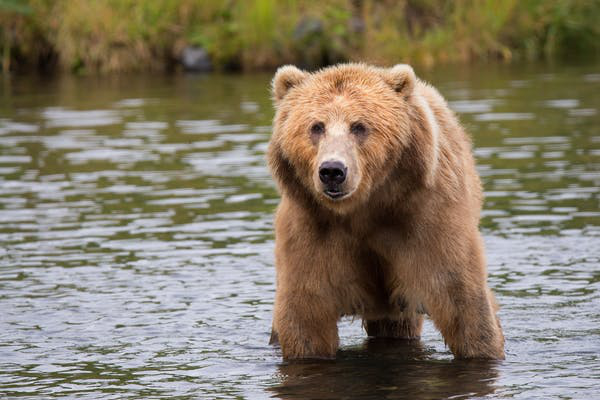

In [4]:
# show image
im_select = 'bear'
im = load_image_from_path(image_urls[im_select])
display(im)

In [5]:
# load + transform image
full_size = min(im.size)
crop = transforms.CenterCrop(full_size)
im_crop = crop(im)
im_crop.save(f'outputs/{im_select}.png')

In [6]:
preprocess = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
x = preprocess(im_crop)[None]

In [7]:
# run inference
outputs, decisions = model.forward_with_decisions(x)
_, predicted = outputs.max(1)
cls = DATASET_TO_CLASSES['CIFAR10'][predicted[0]]
print('Prediction:', cls)
print('Decisions:')
print('\n'.join([
    f"  {info['prob']:7.2%} {info['name']}" for info in decisions[0]
][1:]))

Prediction: dog
Decisions:
   99.95% vertebrate
   99.98% placental
   99.98% carnivore
  100.00% dog


In [8]:
# node = decisions[0][-2]['node']
# preds = [node.wnids.index(c) for c in node.children]
# closest = preds[1] if predicted == preds[0] else preds[0]
# print('Nearest Contender:', DATASET_TO_CLASSES['CIFAR10'][closest])

In [9]:
# Extract the backbone (conv layers) and set up Grad-CAM for them
backbone = model.model
gradcam = GuidedGradCam(backbone, layer=backbone.features.final_pool)

In [10]:
# Run some backprop to get the Grad-CAM attributes
backbone.zero_grad()
attr_gc = gradcam.attribute(x, target=predicted[0])
# attr_gc = gradcam.attribute(x, target=predicted) \
#         - gradcam.attribute(x, target=closest)

In [11]:
upscale = transforms.Resize(full_size, Image.NEAREST)

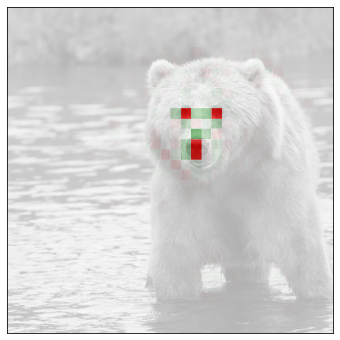

In [12]:
# Visualize Grad-CAM on top of cropped image
attr_gc_up = upscale(attr_gc)
attr_gc_np = np.transpose(attr_gc_up.squeeze().cpu().detach().numpy(), (1, 2, 0))
fig, ax = vis.visualize_image_attr(attr_gc_np, im_crop, method='blended_heat_map', sign='all', alpha_overlay=0.7)
fig.savefig(f'outputs/{im_select}_gradcam.pdf')